In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

In [ ]:
df= pd.read_csv("/content/international-airline-passengers.csv", index_col="Month", parse_dates= True)
df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60":'Thousands of Passengers'},inplace=True)
df.head()

,Thousands of Passengers
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [ ]:
len(df)

145

In [ ]:
df.dropna(inplace=True)

In [ ]:
len(df)

144

In [ ]:
df.index= pd.to_datetime(df.index)
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

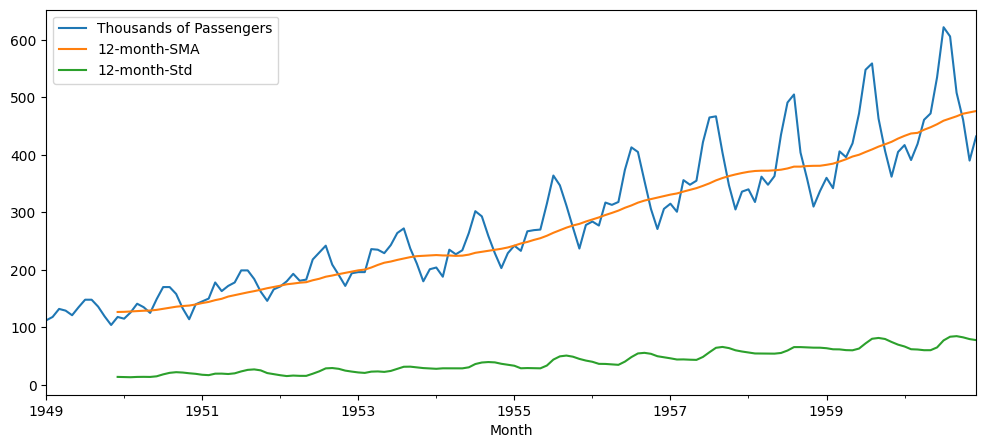

In [ ]:
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()
df['12-month-Std'] = df['Thousands of Passengers'].rolling(window=12).std()

df[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot(figsize=(12,5));

In [ ]:
df.columns

Index(['Thousands of Passengers', '12-month-SMA', '12-month-Std'], dtype='object')

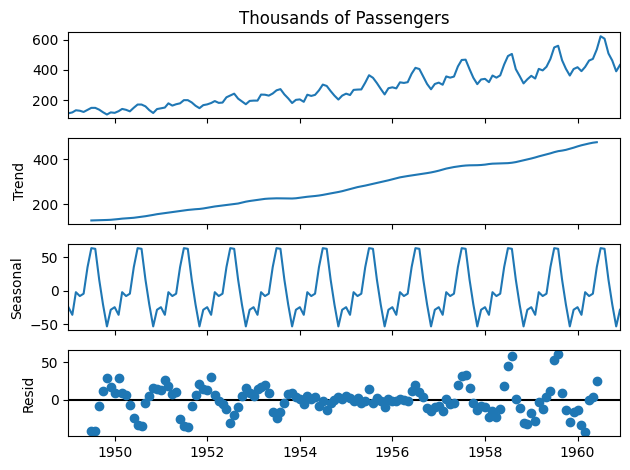

In [ ]:
ssn= seasonal_decompose(df["Thousands of Passengers"], model="add")
ssn.plot();

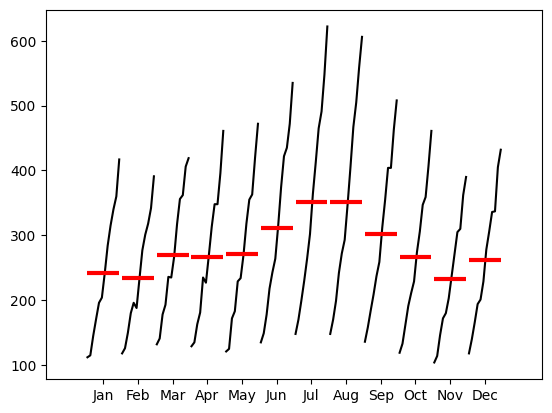

In [ ]:
month_plot(df['Thousands of Passengers']);

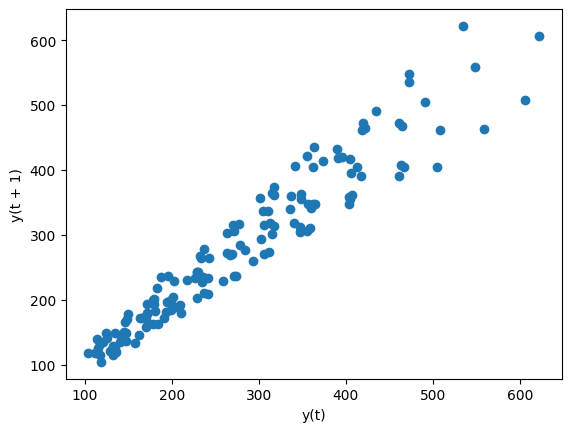

In [ ]:
lag_plot(df['Thousands of Passengers']);

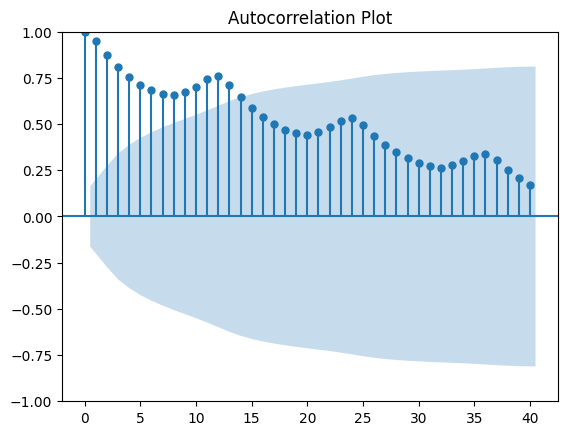

In [ ]:
title = 'Autocorrelation Plot'
lags = 40
plot_acf(df["Thousands of Passengers"],title=title,lags=lags);

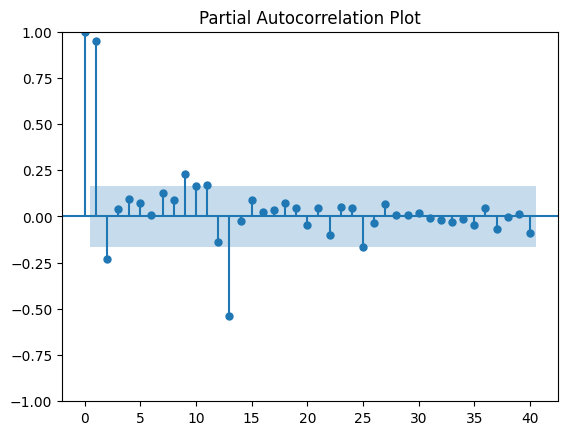

In [ ]:
title = 'Partial Autocorrelation Plot'
lags = 40
plot_pacf(df["Thousands of Passengers"],title=title,lags=lags);

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df["Thousands of Passengers"])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<Axes: xlabel='Month'>

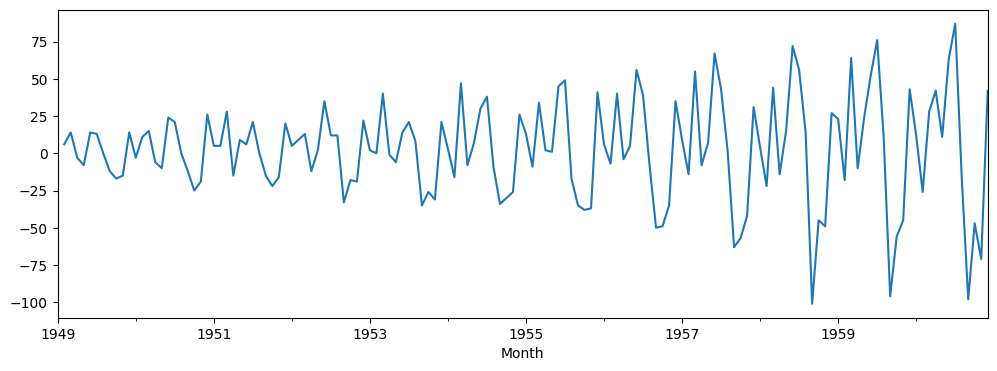

In [ ]:
df["difference_1"]= diff(df["Thousands of Passengers"], k_diff=1)
df["difference_1"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_1"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.829267
p-value                   0.054213
# lags used              12.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<Axes: xlabel='Month'>

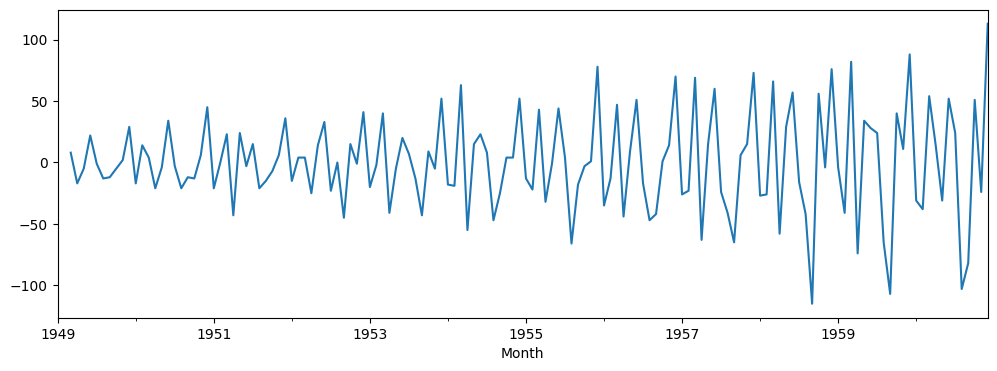

In [ ]:
df["difference_2"]= diff(df["Thousands of Passengers"], k_diff=2)
df["difference_2"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_2"])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


<Axes: xlabel='Month'>

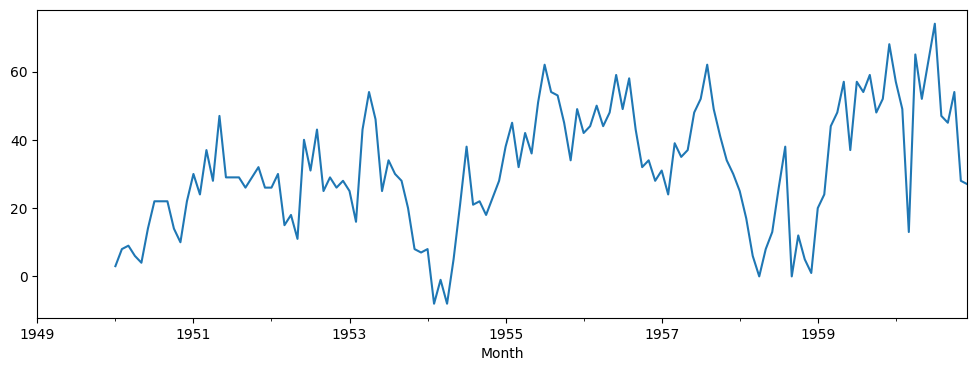

In [ ]:
df["difference_seasonal"]= diff(df["Thousands of Passengers"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_seasonal"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.383021
p-value                   0.011551
# lags used               1.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
df['Weighted_Price_box'], lmbda = stats.boxcox(df["Thousands of Passengers"])
adf_test(df["Weighted_Price_box"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.326071
p-value                   0.617162
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
train= df.iloc[:len(df)-12]
test= df.iloc[len(df)-12:]

In [ ]:
auto_arima_results= auto_arima(train["Thousands of Passengers"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3, # maximum p and q
           m=1,              # frequency of series
           d=None,           # let model determine 'd'
           seasonal=False,   # No Seasonality
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=1.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Tue, 04 Jun 2024   AIC                           1218.683
Time:                        08:54:07   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8460     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

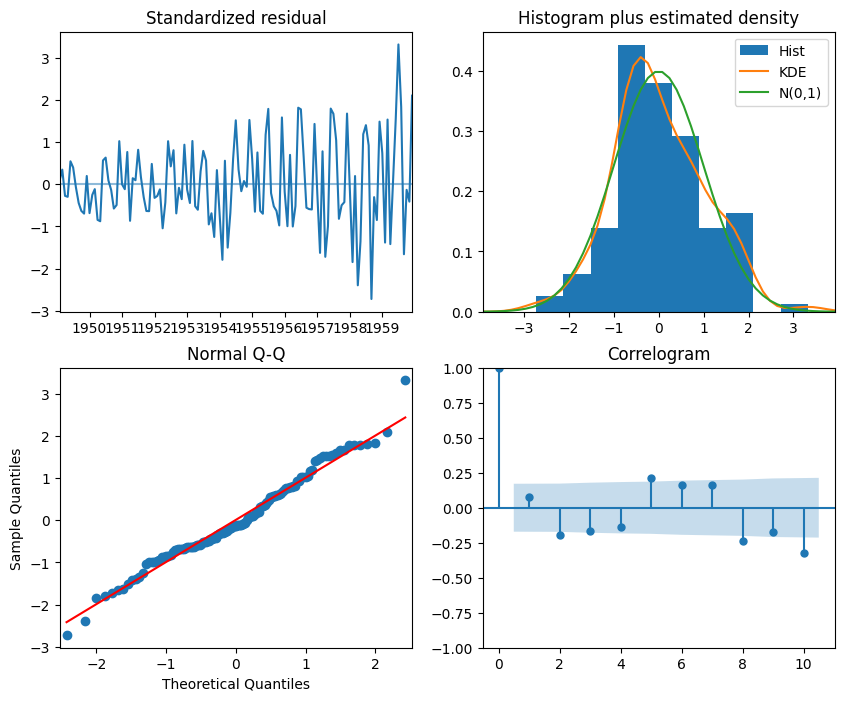

In [ ]:
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
arima_model= ARIMA(train["Thousands of Passengers"], order= (2,1,2))
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
normaltest(arima_model_fit.resid)

NormaltestResult(statistic=14.0113003611032, pvalue=0.0009067441961382057)

In [ ]:
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'Actual v/s Predictions for Test dataset'}, xlabel='Month'>

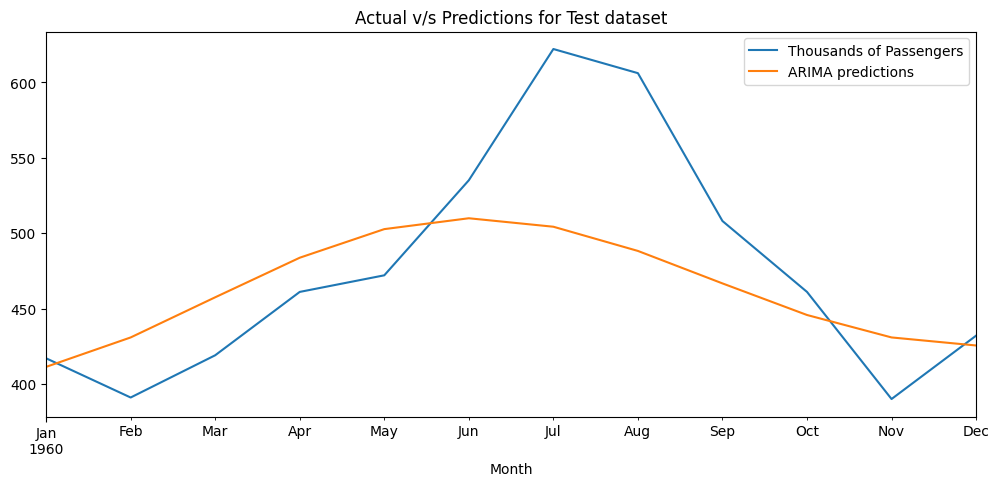

In [ ]:
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True);
pred.plot(legend=True)

In [ ]:
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_arima= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_arima} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 55.22283915688796 

Mean Square Error is 3049.561964547518


In [ ]:
smodel = auto_arima(train["Thousands of Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.85 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=1.03 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=1.36 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=3.60 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.70 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.01 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Tue, 04 Jun 2024   AIC                            905.686
Time:                                    08:55:44   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Root Mean Square is 17.81560143047715 

Mean Square Error is 317.39565432961956


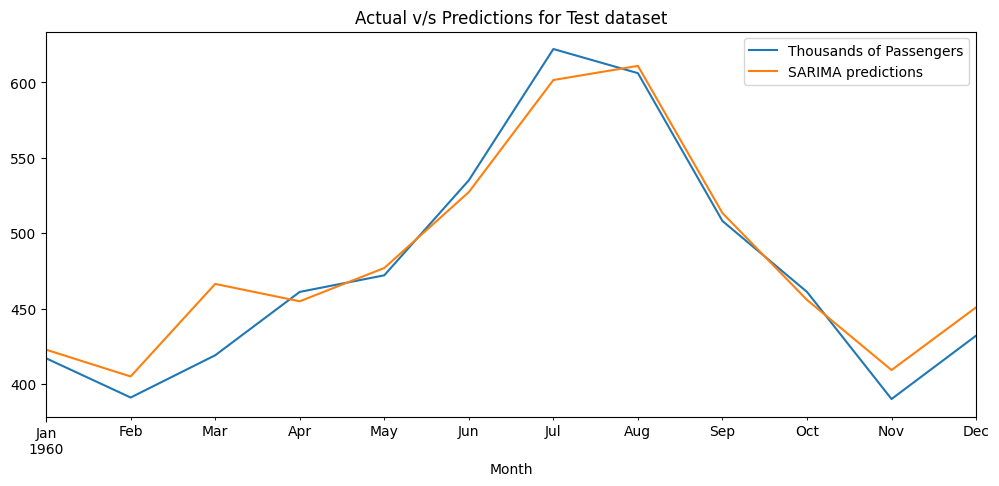

In [ ]:
sarima_model= SARIMAX(train["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()

#Make predictions on Test
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

#Plot the predictions on Test
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)


#Evaluate the model
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarima= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_sarima} \n")
print(f"Mean Square Error is {mse}")

In [ ]:
# Compute Seasonal Index
# multiplicative seasonal component
result_mul = seasonal_decompose(train['Thousands of Passengers'],   # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the Train data
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # reassign the index


# merge with the Test data
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # reassign the index

<ipython-input-36-e7a2b0aa2f2f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-36-e7a2b0aa2f2f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
# SARIMAX Model
sxmodel = auto_arima(train2["Thousands of Passengers"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=1.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=3.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.85 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=2.69 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.72 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.10 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Tue, 04 Jun 2024   AIC                            905.686
Time:                                    08:56:46   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Root Mean Square is 20.540661836746057 

Mean Square Error is 421.91878869155585


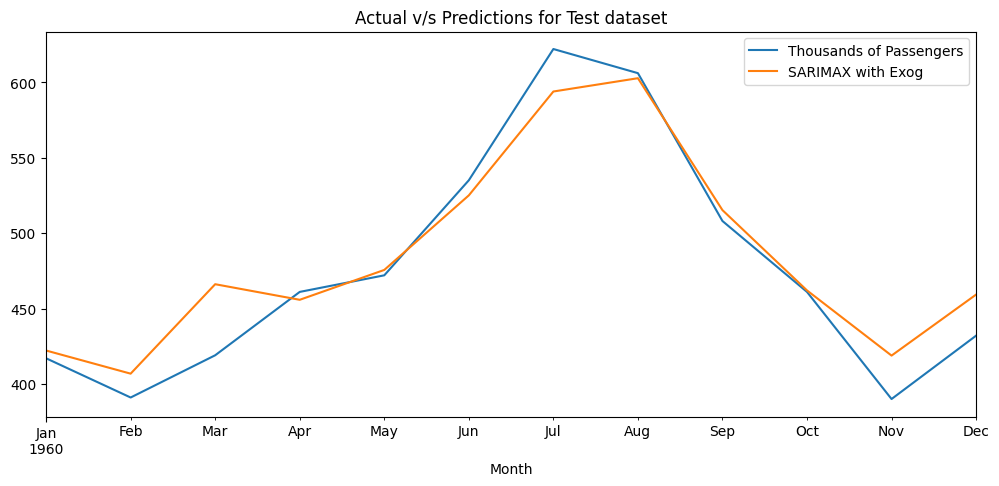

In [ ]:
sarimax_model= SARIMAX(train2["Thousands of Passengers"], order= (1,1,0), seasonal_order= (1,0,0,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

#Predict on Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

#Plot predictions on Test
title= "Actual v/s Predictions for Test dataset"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

#Evaluate the model
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarimax= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'Current observations and Future forecasts'}, xlabel='Month'>

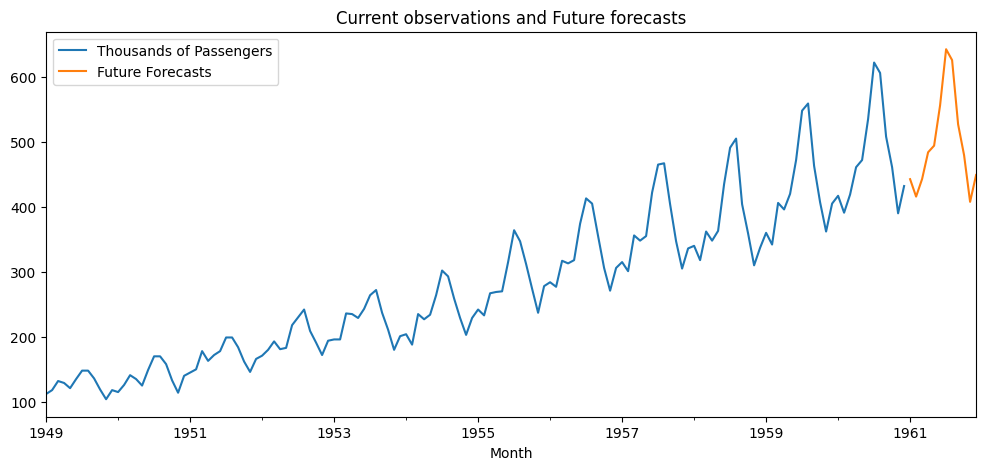

In [ ]:
model= SARIMAX(df["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
results= model.fit()

start= len(df)
end= len(df) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")
title= "Current observations and Future forecasts"
df["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)